In [145]:
import pandas as pd
import numpy as np

In [146]:
# df = pd.read_csv('final_dataset.csv')

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [148]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

In [149]:
# CSV 파일을 읽어들입니다.
df = pd.read_csv('semi_dataset.csv')

# 특성과 레이블을 분리합니다.
X = df.drop('label', axis=1).values  # 특성 데이터
y = df['label'].values  # 레이블 데이터


# 훈련 세트와 나머지(검증+테스트) 세트로 분할합니다. (80% : 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = scaler.fit_transform(X_train)
X_temp = scaler.transform(X_temp)

# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_temp = X_temp.reshape((X_temp.shape[0], 1, X_temp.shape[1]))

# 나머지 데이터를 검증 세트와 테스트 세트로 분할합니다. (50% : 50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 분할된 데이터 세트의 크기를 출력합니다.
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 분할된 데이터 세트의 레이블 분포를 출력합니다.
print(f"Train set label distribution: {np.bincount(y_train.astype(int))}")
print(f"Validation set label distribution: {np.bincount(y_val.astype(int))}")
print(f"Test set label distribution: {np.bincount(y_test.astype(int))}")

Train set: 2605 samples
Validation set: 326 samples
Test set: 326 samples
Train set label distribution: [1631  974]
Validation set label distribution: [204 122]
Test set label distribution: [204 122]


In [150]:
X_train.shape

(2605, 248)

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
from pycaret.classification import *

In [152]:
# # PyCaret 설정
# # train_size를 0.8로 설정하여 학습 데이터와 테스트 데이터를 80:20으로 분할
# exp_clf = setup(data = df, target = 'label', session_id=123, train_size=0.8)

# # 모든 분류 모델을 AUC 기준으로 비교
# best_model = compare_models(sort = 'Accuracy')

# # 가장 성능이 좋은 모델을 출력합니다.
# print(best_model)

In [153]:
# # PyCaret 설정
# exp_clf = setup(data = df, target = 'label', session_id=123)

# # CatBoost 모델 생성
# cat_model = create_model('catboost', fold = 5)

# # 모델 학습
# cat_tuned = tune_model(cat_model, optimize = 'Accuracy')

# # 검증 세트를 이용한 예측
# predictions = predict_model(cat_tuned)

# # 모델의 성능 평가
# evaluate_model(cat_tuned)

[LightGBM] [Info] Number of positive: 974, number of negative: 1631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63240
[LightGBM] [Info] Number of data points in the train set: 2605, number of used features: 248
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373896 -> initscore=-0.515537
[LightGBM] [Info] Start training from score -0.515537
Validation Accuracy (LightGBM): 0.8589
Test Accuracy (LightGBM): 0.8712

Classification Report (Test set - LightGBM):
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       204
           1       0.82      0.84      0.83       122

    accuracy                           0.87       326
   macro avg       0.86      0.86      0.86       326
weighted avg       0.87      0.87      0.87       326



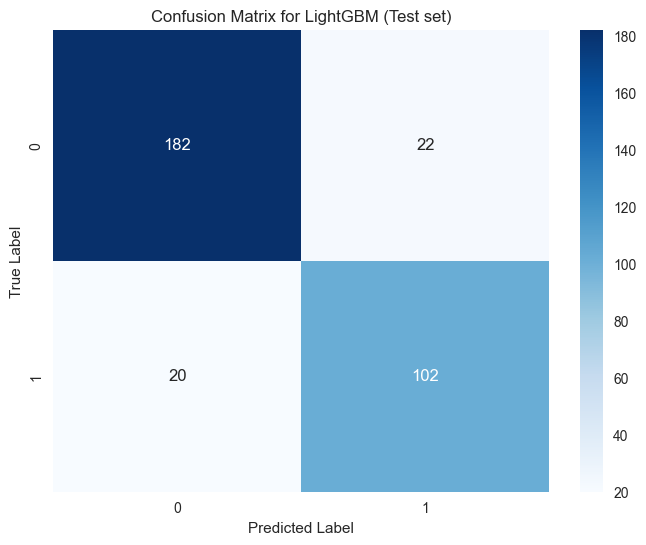

In [231]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create an instance of the LightGBM Classifier
lgbm_classifier = LGBMClassifier()  # You can adjust hyperparameters here

# Train the LightGBM model on the training data
lgbm_classifier.fit(X_train, y_train)

# Validation set evaluation
y_pred_val_lgbm = lgbm_classifier.predict(X_val)
accuracy_val_lgbm = accuracy_score(y_val, y_pred_val_lgbm)
print(f"Validation Accuracy (LightGBM): {accuracy_val_lgbm:.4f}")

# Test set evaluation
y_pred_test_lgbm = lgbm_classifier.predict(X_test)
accuracy_test_lgbm = accuracy_score(y_test, y_pred_test_lgbm)
print(f"Test Accuracy (LightGBM): {accuracy_test_lgbm:.4f}")

# Classification report and confusion matrix for test set
class_report_test_lgbm = classification_report(y_test, y_pred_test_lgbm)
print("\nClassification Report (Test set - LightGBM):")
print(class_report_test_lgbm)

conf_matrix_test_lgbm = confusion_matrix(y_test, y_pred_test_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_lgbm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LightGBM (Test set)')
plt.show()


In [232]:
# 훈련 세트에 대한 예측을 수행합니다.
y_train_pred = lgbm_classifier.predict(X_train)

# 훈련 세트의 정확도를 계산하고 출력합니다.
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# 검증 세트를 이용해 예측을 수행합니다.
y_pred = lgbm_classifier.predict(X_val)

# 검증 세트의 정확도를 계산하고 출력합니다.
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 과적합 확인
if train_accuracy > val_accuracy:
    print('The model is overfitting.')
else:
    print('The model is not overfitting.')

Training Accuracy: 0.9858
Validation Accuracy: 0.8589
The model is overfitting.


### **PyAudio Setup**

In [233]:
import pyaudio

In [234]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
SAMPLE_RATE = 16000
CHUNK = int(SAMPLE_RATE / 30)

audio = pyaudio.PyAudio()

In [235]:
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

In [236]:
import librosa

continue_recording = True

def stop():
    global continue_recording
    continue_recording = False

def extract_log_mel_spectrogram(waveform):
    n_fft_value = min(2048, len(waveform))
    spectrogram_features = librosa.feature.melspectrogram(y=waveform, sr=SAMPLE_RATE, n_fft=n_fft_value, n_mels=248)
    spectrogram_features = librosa.power_to_db(spectrogram_features, ref=np.max)
    return np.mean(spectrogram_features, axis=1).reshape(1, -1)

def start_recording():
    stream = audio.open(format=FORMAT, channels=CHANNELS, rate=SAMPLE_RATE, input=True, frames_per_buffer=CHUNK)
    data = []
    global continue_recording
    continue_recording = True

    while continue_recording:
        audio_chunk = stream.read(CHUNK)
        data.append(audio_chunk)

        waveform = np.frombuffer(audio_chunk, dtype=np.int16) / 32768.0
        waveform = waveform.astype(np.float32)
        
        spectrogram_aggregated = extract_log_mel_spectrogram(waveform)
        
        if spectrogram_aggregated.shape[1] != scaler.n_features_in_:
            raise ValueError(f"Incorrect number of features. Expected {scaler.n_features_in_}, got {spectrogram_aggregated.shape[1]}")
        
        spectrogram_scaled = scaler.transform(spectrogram_aggregated)
        fall_detection_prediction = lgbm_classifier.predict(spectrogram_scaled)

        if fall_detection_prediction == 1:
            print("Fall Detected")
            stop()  # Stop recording if fall is detected

In [241]:
start_recording()

Fall Detected
